  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Loading SIIF Current


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Loading MPT


 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.67it/s]

Loading SIIF Balanced


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Loading NDQ


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.63it/s]

Loading A200


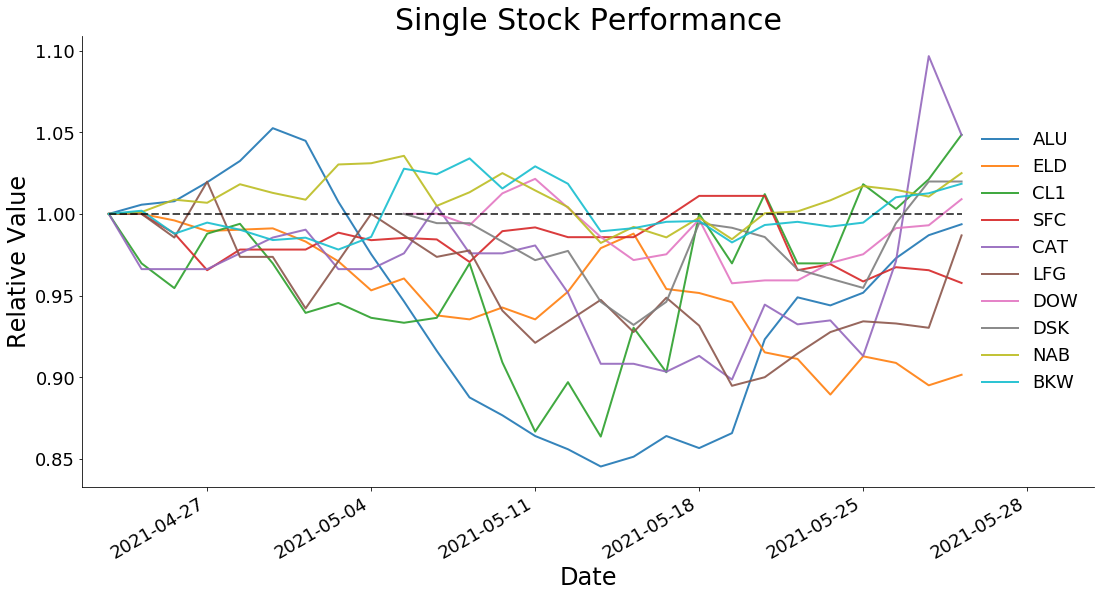

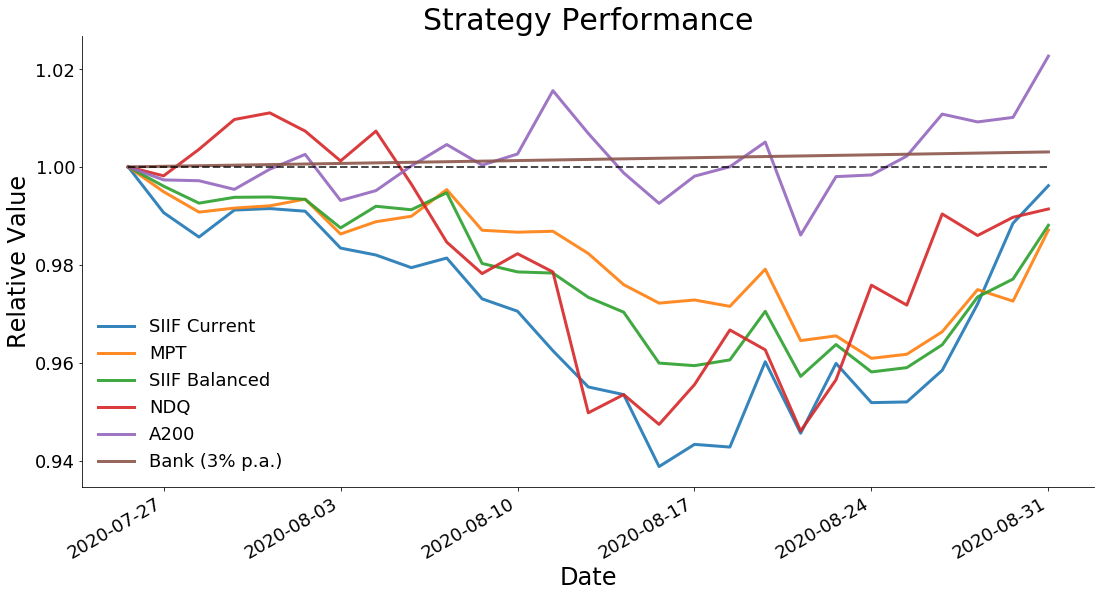

==== Begin emailing at 2021-05-30 16:25:00.986700 ====

Email to    Cameron succeeded at 2021-05-30 16:25:09.737596

==== Completed emailing at 2021-05-30 16:25:09.737596 ====




In [2]:
############################################### TODO ################################################
# - Add Do Not Reply message (footnote?)
# - Add custom stocks to weekly report
# - Get script to run automatically
# - Check day of week and
#     - If Friday night send weekly report
#     - If Weekday send stock alerts based on movement triggers
# - Abstract Email sending & Logging
# - Add to README
# - Improve MPT notebook
# - Automate on Raspberry Pi!

import pandas as pd
import datetime as dt
from siif_utils import Comp, plot_shares, plot_comps, send_email, attach_file, attach_image
import warnings
warnings.filterwarnings("ignore")

TEST, PROD = 0, 1
SIIF = 1

############## INPUT PARAMETERS ##############
PORTFOLIO = SIIF                           
RUNNING_LEVEL = TEST
##############################################

if PORTFOLIO == TEST:
    RUNNING_LEVEL = TEST

####################################### STEP 1. PREPARE DATA ########################################

# Composition Name: Composition CSV file
test_comps = {'SIIF Current': 'TEST'}
siif_comps = {'SIIF Current': 'SIIF', 'MPT': 'MPT',  'SIIF Balanced': 'SIIF_MPT', 'NDQ': 'NDQ', 'A200': 'A200',}
names = test_comps if PORTFOLIO == TEST else siif_comps
# ENSURE THAT THE MAIN PORTFOLIO IS ADDED TO `comps` FIRST
comps = [Comp(name, names[name]) for name in names]
    
######################################### STEP 2. PLOT DATA #########################################
plot_shares(comps[0], save=True)
plot_comps(comps, save=True)

######################################## STEP 3. SEND EMAILS ########################################
# Stock Alert Report Automaton
# SIIF Automated Reporting Assistant
# - Sara

import cgi
import uuid
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.header import Header

TEST_NAME = 'Cameron'

def log(typ, name='', running_level=RUNNING_LEVEL, verbose=True):
    ''' Log the emailing process. Log to log.txt if running_level is PROD, print if verbose is True '''
    # What is the message
    if typ == 'begin':
        msg = '==== Begin emailing at ' + str(dt.datetime.now()) + ' ====\n'
    elif typ == 'success':
        msg = f'Email to {name.rjust(10)} succeeded at ' + str(dt.datetime.now()) + '\n'
    elif typ == 'failure':
        msg = f'Email to {name.rjust(10)} failed at ' + str(dt.datetime.now()) + '\n'
    elif typ == 'end':
        msg = '==== Completed emailing at ' + str(dt.datetime.now()) + ' ====\n\n'
    
    # Where to log
    if running_level == PROD:
        with open('log.txt', 'a') as f:
            f.write(msg)
    if verbose:
        print(msg)
        
# Load analyst emails
emails = pd.read_csv('./data/emails.csv')
ANALYSTS_TEST = emails[emails['name'] == TEST_NAME]
ANALYSTS_PROD = emails
ANALYSTS = ANALYSTS_PROD if RUNNING_LEVEL == PROD else ANALYSTS_TEST

gmail_user = "sarasiifbot@gmail.com"
with open('./data/password.txt') as f:
    gmail_pwd = f.read()

LOGO_PATH = './images/SIIF Logo.png'
LOGO_SCALE = (258, 155)
GRAPH_SCALE = (691, 389)

def generate_email(gmail_user, to, img_dict, name='Analyst'):
    msg = MIMEMultipart('related')
    msg['Subject'] = Header(u'SIIF Weekly Report', 'utf-8')
    msg['From'] = gmail_user
    msg['To'] = to
    msg_alternative = MIMEMultipart('alternative')
    msg_text = MIMEText(u'Image not working', 'plain', 'utf-8')
    msg_alternative.attach(msg_text)
    msg.attach(msg_alternative)

    msg_html = u'<p>Dear {},</p>'.format(name)
    msg_html += u'<p>Here are the portfolio results:</p>'
    
    # Strategy Comparison
    portfolio = comps[0].portfolio_value
    last_week_date = portfolio.index[-1] - pd.Timedelta(days=7)
    last_week_value = portfolio[portfolio.index <= last_week_date][-1]
    pct = round(100*(portfolio[-1]/last_week_value - 1), 1)
    msg_html += u'<p>The current portfolio value is ${}, that is {}% {} from last week.</p>'.format(
        round(portfolio[-1], 2), pct, "up" if pct >= 0 else "down")
    
    msg_html += '<div dir="ltr">''<img src="cid:{cid}" alt="{alt}" width="{w}" height="{h}"><br></div>'.format(
                alt=cgi.escape('image not found', quote=True), w=GRAPH_SCALE[0], h=GRAPH_SCALE[1], **img_dict[0])
    msg_html += u"<p>The above graph compares SIIF's current portfolio against several other strategies. They are:</p>"
    msg_html += u"<p>Using Modern Portfolio Theory to pick from original 40, using MPT to balance the SIIF portfolio, " + \
        u"investing entirely in the NASDAQ 100, ASX 200, or into a generous 3% savings account.</p>"
    
    # SIIF Current Breakdown
    msg_html += u"<p>Here is the breakdown of SIIF's current portfolio:</p>"
    
    msg_html += '<div dir="ltr">''<img src="cid:{cid}" alt="{alt}" width="{w}" height="{h}"><br></div>'.format(
                alt=cgi.escape('image not found', quote=True), w=GRAPH_SCALE[0], h=GRAPH_SCALE[1], **img_dict[1])
    
    # Add sign-off and logo
    msg_html += '<p>Have a great day!</p><p>From Sara (SIIF Automated Reporting Assistant)</p>'
    msg_html += '<div dir="ltr">''<img src="cid:{cid}" alt="{alt}" width="{w}" height="{h}"><br></div>'.format(
                alt=cgi.escape('image not found', quote=True), w=LOGO_SCALE[0], h=LOGO_SCALE[1], **img_dict[2])
    
    msg_html += u"<p>---------------------------------</p>"
    msg_html += u"<p>Do not reply to this email</p><p>Code available at https://github.com/CameronChandler/SARA</p>"

    msg_html = MIMEText(msg_html, 'html', 'utf-8')
    msg_alternative.attach(msg_html)
    for img in img_dict:
        msg.attach(attach_image(img))

    return msg

img_dict = []
all_files = [('./images/strategy_comparison.png', GRAPH_SCALE), ('./images/single_stocks.png', GRAPH_SCALE),
             (LOGO_PATH, LOGO_SCALE)]

for file, scale in all_files:
    img_dict_single = dict(title=file, path=file, cid=str(uuid.uuid4()), scale=scale)
    img_dict.append(img_dict_single)

log('begin')
for i, row in ANALYSTS.iterrows():
    name, email = row['name'], row['email']
    if RUNNING_LEVEL == TEST and name != TEST_NAME:
        continue

    try:
        email_msg = generate_email(gmail_user, email, img_dict=img_dict, name=name)
        send_email(email_msg, gmail_user, gmail_pwd, email)
        log('success', name)
    except:
        log('failure', name)
        
log('end')